In [43]:
import pandas as pd
import numpy as np
import scipy
import gradio as gr


In [44]:
df = pd.read_csv('data.csv')

In [45]:
df = df.drop(['beats'], axis=1)

In [46]:
df['class_name'] = df['class_name'].astype('category')
df['class_label'] = df['class_name'].cat.codes

In [47]:
lookup_genre_name = dict(zip(df.class_label.unique(), df.class_name.unique()))

In [48]:
cols = list(df.columns)
cols.remove('label')
cols.remove('class_label')
cols.remove('class_name')


In [49]:
%matplotlib notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X = df.iloc[:,1:28]
y = df['class_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

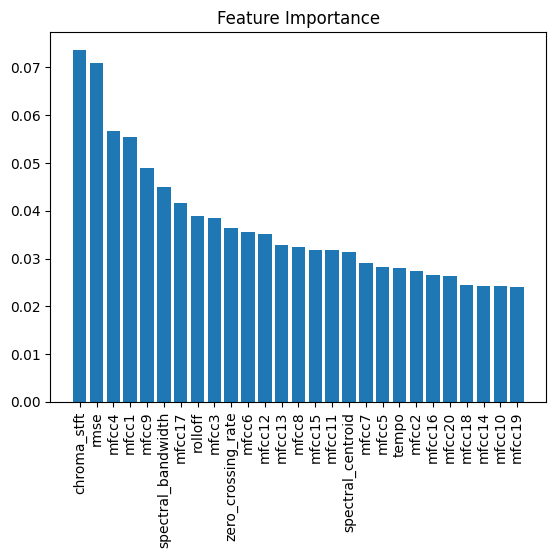

In [51]:
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
clf = RandomForestClassifier(random_state=0, n_jobs=-1).fit(X_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns.values[i] for i in indices]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

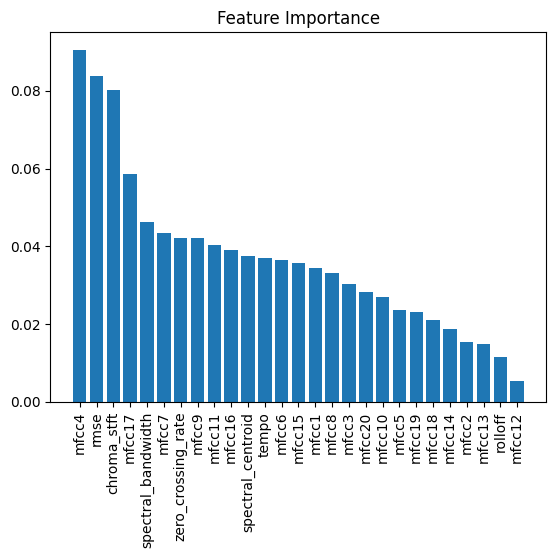

In [52]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0).fit(X_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns.values[i] for i in indices]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.624

In [54]:
def getmetadata(filename):
    import librosa
    import numpy as np
    

    y, sr = librosa.load(filename)
    #fetching tempo

    onset_env = librosa.onset.onset_strength(y =y, sr = sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)

    #fetching beats

    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,sr=sr)

    #chroma_stft

    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)

    #rmse

    rmse = librosa.feature.rms(y=y)

    #fetching spectral centroid

    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

    #spectral bandwidth

    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    #fetching spectral rolloff

    spec_rolloff = librosa.feature.spectral_rolloff(y=y+0.01, sr=sr)[0]

    #zero crossing rate

    zero_crossing = librosa.feature.zero_crossing_rate(y)

    #mfcc

    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    #metadata dictionary

    metadata_dict = {'tempo':tempo,'chroma_stft':np.mean(chroma_stft),'rmse':np.mean(rmse),
                     'spectral_centroid':np.mean(spec_centroid),'spectral_bandwidth':np.mean(spec_bw),
                     'rolloff':np.mean(spec_rolloff), 'zero_crossing_rates':np.mean(zero_crossing)}

    for i in range(1,21):
        metadata_dict.update({'mfcc'+str(i):np.mean(mfcc[i-1])})

    return list(metadata_dict.values())

In [55]:
def file_to_text(filename):
    a = getmetadata(filename)
    d1 =np.array(a)
    data1 = scaler.transform([d1])
    genre_prediction = knn.predict(data1)
    return lookup_genre_name[genre_prediction[0]]

In [56]:
# d1 =np.array(a)
# data1 = scaler.transform([d1])
# genre_prediction = knn.predict(data1)
# txt=lookup_genre_name[genre_prediction[0]]

gr.Interface(fn=file_to_text, inputs=['file'], outputs=['text'], title="WAV Metadata").launch(share=True)

Running on local URL:  http://127.0.0.1:7863
IMPORTANT: You are using gradio version 4.27.0, however version 4.29.0 is available, please upgrade.
--------

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


C:\Users\mokan\AppData\Local\Temp\ipykernel_5560\2602120960.py:10: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\mokan\AppData\Local\Temp\ipykernel_5560\2602120960.py:10: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
